In [1]:
import numpy as np
import time
import copy
from tqdm import tqdm
import os
import sys
sys.path.append('../')

import importlib

import matplotlib as mpl
from matplotlib import pyplot as plt

from collections import OrderedDict

import torch
from torch.optim import SGD, Adam, lr_scheduler
device = 'cuda'

import importlib

import TheoryCurves
importlib.reload(TheoryCurves)

import auxFuncs
importlib.reload(auxFuncs)

import pytz
from datetime import datetime
from dateutil.relativedelta import relativedelta
tz = pytz.timezone('US/Eastern')

def time_now():
    return datetime.now(tz)

def time_diff(t_a, t_b):
    t_diff = relativedelta(t_b, t_a)  # later/end time comes first!
    return '{h}h {m}m {s}s'.format(h=t_diff.hours, m=t_diff.minutes, s=t_diff.seconds)

In [2]:
colors = ['tab:blue', 'tab:red', 'tab:green', 'tab:purple', 'tab:orange', 'tab:brown', 'tab:pink', 'tab:olive', 'tab:cyan']
linestyles = ['-', '--', ':', '-.']
markerstyles = ['.','*','x']

In [3]:
#Width and height of axes.
w=2.5
h=2
plt.rcParams.update({'font.size': 12, 'figure.figsize': [w,h]})

SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rcParams['legend.title_fontsize'] = 'small'

#Helper Function for setting figure size by axis size.
#set_size(w,h,ax)
def set_size(w,h, ax=None):
    """ w, h: width, height in inches """
    if not ax: ax=plt.gca()
    l = ax.figure.subplotpars.left
    r = ax.figure.subplotpars.right
    t = ax.figure.subplotpars.top
    b = ax.figure.subplotpars.bottom
    figw = float(w)/(r-l)
    figh = float(h)/(t-b)
    ax.figure.set_size_inches(figw, figh)

In [4]:
#Reload Data:
outputDict = np.load('output_dict.npy', allow_pickle = True).item()

In [5]:
outputDict.keys()

dict_keys(['num_samples_list', 'lams', 'test_err', 'Ordering', 'projType', 'sigma_s', 'sigma_0', 'eta', 'zeta', 'nus', 'aveGTW'])

In [6]:
outputDict['Ordering']

['nuInd', 'lamInd', 'pInd', 'trial']

In [7]:
num_samples_list = outputDict['num_samples_list']
lams =  outputDict['lams']
test_err = outputDict['test_err']
eta = outputDict['eta']
sigma_s = outputDict['sigma_s']
sigma_0 = outputDict['sigma_0']
zeta = outputDict['zeta']
nus = outputDict['nus']

In [8]:
c = sigma_s[0,1].item()

In [9]:
num_trials = test_err.shape[-1]

## Calculate Theory Curve: A_list

In [10]:
importlib.reload(TheoryCurves)

<module 'TheoryCurves' from '/n/home07/bruben/Simulations/Ensemble_Master/InterpThresh_GlobCorr/../TheoryCurves.py'>

In [11]:
M = sigma_s.shape[0]
alpha_min = num_samples_list[0]/M
alpha_max = num_samples_list[-1]/M
alphas_theory = np.linspace(alpha_min, alpha_max, 5000)
for nu in nus:
    index = np.argmin(np.abs(alphas_theory - nu))
    alphas_theory[index] = nu

TotErrors = np.zeros((len(nus), len(lams), len(alphas_theory)))
for nuInd, nu in enumerate(nus):
    for lamInd, lam in enumerate(lams):
        TotErrors[nuInd, lamInd] = TheoryCurves.getGlobCorrErrorCurve(alphas_theory, [nu], c, lam, zeta, eta, exclusive = True)

In [12]:
# #ax.errorbar(num_samples_list, tr_err[KInd, ConnDistInd, :, lamInd, EnsFuncInd, :].mean(1), tr_err[KInd, ConnDistInd, :, lamInd, EnsFuncInd, :].std(1), ls = linestyles[ConnDistInd], color = colors[EnsFuncInd], lw = 1, marker = markerstyles[0], label = ConnDist + ', ' + EnsFunc)
# for lamInd, lam in enumerate(lams):
#     fig, ax = plt.subplots()
#     ax.plot(num_samples_list, tr_err[:, lamInd, :].mean(1))
#     ax.set_ylabel('Training Error')
#     ax.set_xlabel(r'$P$')
#     ax.set_title(r'$\lambda$ = ' + str(lam))

# #ax.legend(custom_lines, ['Shift = ' + str(shift) for shift in shift_list] + ['K = '+str(K) for K in KVals], bbox_to_anchor = (1.9, 1), loc = 'upper right')
# #ax.legend(bbox_to_anchor = (1.05, 1), loc = 'upper left')

# #fig = plt.gcf()
# #fig.savefig(figPath+'train_err_plot'+'.pdf', bbox_inches='tight')
# fig.tight_layout()

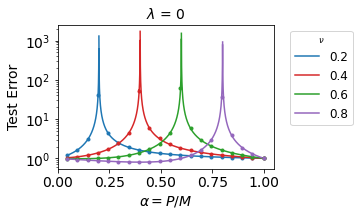

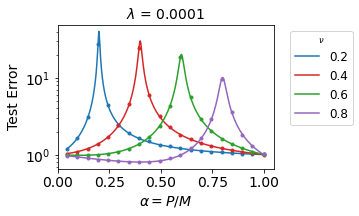

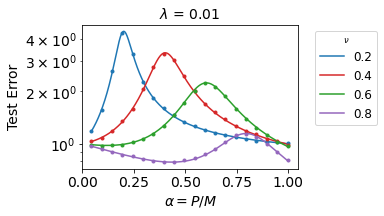

In [15]:
for lamInd, lam in enumerate(lams):

    fig, ax = plt.subplots()
    
    for nuInd, nu in enumerate(nus):
        ax.errorbar(num_samples_list/M, test_err[nuInd,lamInd,:, :].mean(1), test_err[nuInd,lamInd,:,:].std(1)/np.sqrt(test_err.shape[-1]), marker = '.', ls = '', color = colors[nuInd])
        #ax.plot(num_samples_list/M, test_err[nuInd,lamInd,:, :].mean(1), marker = '.', ls = '', color = colors[nuInd])
        ax.plot(alphas_theory, TotErrors[nuInd, lamInd],  color = colors[nuInd], label =str(nu))

        ax.set_ylabel('Test Error')
        ax.set_xlabel(r'$\alpha = P/M$')
        ax.set_title(r'$\lambda$ = ' + str(lam) )

        ax.set_xlim([0, ax.get_xlim()[1]])
        ax.set_yscale('log')
        #ax.set_ylim([ax.get_ylim()[0],10**1])

        #ax.legend(custom_lines, ['Shift = ' + str(shift) for shift in shift_list] + ['K = '+str(K) for K in KVals], bbox_to_anchor = (1.9, 1), loc = 'upper right')
        ax.legend(bbox_to_anchor = (1.05, 1), loc = 'upper left', title = r'$\nu$')

        #fig = plt.gcf()
        set_size(3,2)
        fig.savefig('test_err_Interp_lam_'+str(lam)+'.svg', bbox_inches='tight', dpi = 300)
        #fig.tight_layout()